In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

import numpy as np
import pandas as pd
import torch
import tensorflow as tf
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import seaborn as sns
from functools import lru_cache
from joblib import Parallel, delayed
import pickle
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
protbert_model = AutoModel.from_pretrained("Rostlab/prot_bert").to(device)

In [4]:
def load_peptide_data(data_path, max_sequences=50000):
    """
    Load peptide sequences from CSV files with comprehensive error handling and statistics
    """
    therapeutic_path = os.path.join(data_path, "Therapeutic data")
    non_therapeutic_path = os.path.join(data_path, "Non-Therapeutic data")
    
    sequences, labels = [], []
    file_stats = {}
    
    if not os.path.exists(therapeutic_path):
        print(f"Warning: {therapeutic_path} not found!")
        return [], [], {}
    
    if not os.path.exists(non_therapeutic_path):
        print(f"Warning: {non_therapeutic_path} not found!")
        return [], [], {}
    
    print("Loading therapeutic peptides...")
    therapeutic_total = 0
    for filename in os.listdir(therapeutic_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(therapeutic_path, filename)
            try:
                df = pd.read_csv(file_path)
                
                if df.shape[1] >= 1:
                    seqs = df.iloc[:, 0].dropna().astype(str).tolist()
                    seqs = [seq.strip().upper() for seq in seqs if seq.strip()]
                    
                    valid_seqs = []
                    for seq in seqs:
                        clean_seq = ''.join([c for c in seq if c in 'ACDEFGHIKLMNPQRSTVWY'])
                        if 5 <= len(clean_seq) <= 200:
                            valid_seqs.append(clean_seq)
                    
                    # Limit sequences if max_sequences specified
                    if max_sequences and len(sequences) + len(valid_seqs) > max_sequences // 2:
                        remaining = max(0, max_sequences // 2 - len(sequences))
                        valid_seqs = valid_seqs[:remaining]
                    
                    sequences.extend(valid_seqs)
                    labels.extend([1] * len(valid_seqs))
                    therapeutic_total += len(valid_seqs)
                    file_stats[f"therapeutic_{filename}"] = len(valid_seqs)
                    print(f"  ✓ {filename}: {len(valid_seqs)} valid sequences")
                
            except Exception as e:
                print(f"  ✗ Error reading {filename}: {e}")
                continue
    
    print(f"Total therapeutic sequences: {therapeutic_total}")
    
    print("\nLoading non-therapeutic peptides...")
    non_therapeutic_total = 0
    for filename in os.listdir(non_therapeutic_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(non_therapeutic_path, filename)
            try:
                df = pd.read_csv(file_path)
                
                if df.shape[1] >= 1:
                    seqs = df.iloc[:, 0].dropna().astype(str).tolist()
                    seqs = [seq.strip().upper() for seq in seqs if seq.strip()]
                    
                    valid_seqs = []
                    for seq in seqs:
                        clean_seq = ''.join([c for c in seq if c in 'ACDEFGHIKLMNPQRSTVWY'])
                        if 5 <= len(clean_seq) <= 200:
                            valid_seqs.append(clean_seq)
                    
                    # Limit sequences if max_sequences specified
                    if max_sequences and len([l for l in labels if l == 0]) + len(valid_seqs) > max_sequences // 2:
                        remaining = max(0, max_sequences // 2 - len([l for l in labels if l == 0]))
                        valid_seqs = valid_seqs[:remaining]
                    
                    sequences.extend(valid_seqs)
                    labels.extend([0] * len(valid_seqs))
                    non_therapeutic_total += len(valid_seqs)
                    file_stats[f"non_therapeutic_{filename}"] = len(valid_seqs)
                    print(f"  ✓ {filename}: {len(valid_seqs)} valid sequences")
                
            except Exception as e:
                print(f"  ✗ Error reading {filename}: {e}")
                continue
    
    print(f"Total non-therapeutic sequences: {non_therapeutic_total}")
    print(f"Overall total: {len(sequences)} sequences")
    
    return sequences, labels, file_stats

def preprocess_sequences(sequences, labels):
    valid_data = []
    for i, seq in enumerate(sequences):
        if 5 <= len(seq) <= 100 and all(aa in 'ACDEFGHIKLMNPQRSTVWY' for aa in seq):
            valid_data.append((seq, labels[i]))
    
    sequences, labels = zip(*valid_data) if valid_data else ([], [])
    return list(sequences), list(labels)

In [5]:
def extract_statistical_features(sequences):
    """
    Extract comprehensive statistical features from peptide sequences
    Returns enhanced feature set for better model performance
    """
    def calc_features(seq):
        length = len(seq)
        aa_counts = {char: seq.count(char) for char in "ACDEFGHIKLMNPQRSTVWY"}
        
        # Amino acid group compositions
        hydrophobic = "AILMFWV"
        polar = "NQST"
        charged = "KRDEH"
        aromatic = "FWY"
        tiny = "ACSV"
        small = "ABDHNT"
        aliphatic = "ILV"
        
        # Calculate group compositions
        hydrophobicity = sum(aa_counts.get(char, 0) for char in hydrophobic) / length
        polarity = sum(aa_counts.get(char, 0) for char in polar) / length
        aromaticity = sum(aa_counts.get(char, 0) for char in aromatic) / length
        tiny_fraction = sum(aa_counts.get(char, 0) for char in tiny) / length
        small_fraction = sum(aa_counts.get(char, 0) for char in small) / length
        aliphatic_fraction = sum(aa_counts.get(char, 0) for char in aliphatic) / length
        
        # Charge properties
        positive_charge = aa_counts.get('K', 0) + aa_counts.get('R', 0) + aa_counts.get('H', 0)
        negative_charge = aa_counts.get('D', 0) + aa_counts.get('E', 0)
        net_charge = positive_charge - negative_charge
        
        # Structural features
        proline_content = aa_counts.get('P', 0) / length
        glycine_content = aa_counts.get('G', 0) / length
        cysteine_content = aa_counts.get('C', 0) / length
        
        # Hydrophobic moment calculation
        hydrophobic_values = {
            'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
            'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
            'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
            'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
        }
        
        hydrophobic_moment = 0
        for i, aa in enumerate(seq):
            if aa in hydrophobic_values:
                angle = i * 100 * np.pi / 180
                hydrophobic_moment += hydrophobic_values[aa] * np.exp(1j * angle)
        
        return [
            length, hydrophobicity, polarity, net_charge/length, aromaticity,
            tiny_fraction, small_fraction, aliphatic_fraction,
            positive_charge/length, negative_charge/length, abs(net_charge)/length,
            proline_content, glycine_content, cysteine_content,
            abs(hydrophobic_moment)/length
        ]
    
    return np.array([calc_features(seq) for seq in sequences], dtype=np.float32)

def get_protbert_embeddings(sequences, batch_size=8):
    """
    Extract ProtBERT embeddings with optimized memory usage and error handling
    """
    protbert_model.eval()
    embeddings = []
    failed_sequences = 0
    
    print(f"Extracting ProtBERT embeddings for {len(sequences)} sequences...")
    
    with torch.no_grad():
        for i in tqdm(range(0, len(sequences), batch_size), desc="ProtBERT Embedding"):
            try:
                batch_sequences = sequences[i:i + batch_size]
                batch = [" ".join(list(seq)) for seq in batch_sequences]
                
                inputs = tokenizer(
                    batch, 
                    return_tensors="pt", 
                    padding=True, 
                    truncation=True, 
                    max_length=512
                ).to(device)
                
                outputs = protbert_model(**inputs)
                batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
                embeddings.append(batch_embeddings)
                
                # Clear cache periodically
                if i % (batch_size * 10) == 0:
                    torch.cuda.empty_cache() if torch.cuda.is_available() else None
                    
            except Exception as e:
                print(f"Error processing batch {i//batch_size}: {e}")
                failed_sequences += len(batch_sequences)
                # Add zero embeddings for failed sequences
                zero_embeddings = np.zeros((len(batch_sequences), 1024), dtype=np.float32)
                embeddings.append(zero_embeddings)
                continue
    
    if failed_sequences > 0:
        print(f"Warning: Failed to process {failed_sequences} sequences")
    
    final_embeddings = np.vstack(embeddings).astype(np.float32)
    print(f"Generated embeddings shape: {final_embeddings.shape}")
    
    return final_embeddings

In [6]:
def create_advanced_multimodal_model(embedding_dim, statistical_dim):
    """
    Create advanced multi-modal neural network combining ProtBERT embeddings and statistical features
    """
    # Input layers
    embedding_input = Input(shape=(embedding_dim,), name='protbert_embeddings')
    statistical_input = Input(shape=(statistical_dim,), name='statistical_features')
    
    # ProtBERT embedding branch
    emb_branch = Dense(512, activation='relu')(embedding_input)
    emb_branch = BatchNormalization()(emb_branch)
    emb_branch = Dropout(0.3)(emb_branch)
    
    emb_branch = Dense(256, activation='relu')(emb_branch)
    emb_branch = BatchNormalization()(emb_branch)
    emb_branch = Dropout(0.2)(emb_branch)
    
    # Statistical features branch
    stat_branch = Dense(128, activation='relu')(statistical_input)
    stat_branch = BatchNormalization()(stat_branch)
    stat_branch = Dropout(0.3)(stat_branch)
    
    stat_branch = Dense(64, activation='relu')(stat_branch)
    stat_branch = Dropout(0.2)(stat_branch)
    
    # Fusion layer
    combined = concatenate([emb_branch, stat_branch], name='feature_fusion')
    
    # Final classification layers
    dense1 = Dense(512, activation='relu')(combined)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.4)(dense1)
    
    dense2 = Dense(256, activation='relu')(dense1)
    dense2 = BatchNormalization()(dense2)
    dense2 = Dropout(0.3)(dense2)
    
    dense3 = Dense(128, activation='relu')(dense2)
    dense3 = BatchNormalization()(dense3)
    dense3 = Dropout(0.2)(dense3)
    
    dense4 = Dense(64, activation='relu')(dense3)
    dense4 = Dropout(0.1)(dense4)
    
    # Output layer
    output = Dense(1, activation='sigmoid', name='therapeutic_prediction')(dense4)
    
    # Create and compile model
    model = Model(inputs=[embedding_input, statistical_input], outputs=output)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    
    return model

In [7]:
print("=== ADVANCED CNN-LSTM WITH PROTBERT FOR THERAPEUTIC PEPTIDE PREDICTION ===\n")

# Create necessary directories
os.makedirs("../backend/models", exist_ok=True)
os.makedirs("../data/processed", exist_ok=True)

# Load data with correct relative paths
data_path = "../data"
sequences, labels, file_stats = load_peptide_data(data_path, max_sequences=10000)
sequences, labels = preprocess_sequences(sequences, labels)

# Display dataset statistics
if file_stats:
    print("\n📊 Dataset Statistics by File:")
    for file_key, count in file_stats.items():
        print(f"  {file_key}: {count:,} sequences")

print(f"\nFinal dataset: {len(sequences)} sequences")
print(f"Therapeutic: {sum(labels)} ({sum(labels)/len(labels)*100:.1f}%)")
print(f"Non-therapeutic: {len(labels) - sum(labels)} ({(len(labels) - sum(labels))/len(labels)*100:.1f}%)")

if len(sequences) == 0:
    print("ERROR: No valid sequences found!")
    print("Please check your data files in ../data/Therapeutic data/ and ../data/Non-Therapeutic data/")
    exit()

# Handle ProtBERT embeddings with caching
embeddings_file = "../data/processed/protbert_embeddings.npy"
labels_file = "../data/processed/protbert_labels.npy"

if os.path.exists(embeddings_file) and os.path.exists(labels_file):
    print("\n📁 Loading cached ProtBERT embeddings...")
    protbert_embeddings = np.load(embeddings_file)
    cached_labels = np.load(labels_file)
    
    # Verify cache consistency
    if len(protbert_embeddings) == len(sequences) and np.array_equal(cached_labels, labels):
        print("✅ Cache is valid and consistent")
    else:
        print("⚠️  Cache is inconsistent, regenerating embeddings...")
        protbert_embeddings = get_protbert_embeddings(sequences)
        np.save(embeddings_file, protbert_embeddings)
        np.save(labels_file, np.array(labels))
else:
    print("\n🧬 Extracting ProtBERT embeddings (this may take a while)...")
    protbert_embeddings = get_protbert_embeddings(sequences)
    print("💾 Caching embeddings for future use...")
    np.save(embeddings_file, protbert_embeddings)
    np.save(labels_file, np.array(labels))

# Extract enhanced statistical features
print("\n📈 Extracting comprehensive statistical features...")
statistical_features = extract_statistical_features(sequences)
print(f"Statistical features shape: {statistical_features.shape}")

# Feature scaling
print("\n⚖️  Scaling features...")
scaler_protbert = StandardScaler()
scaler_statistical = StandardScaler()

protbert_scaled = scaler_protbert.fit_transform(protbert_embeddings)
statistical_scaled = scaler_statistical.fit_transform(statistical_features)

# Save scalers
with open("../backend/models/protbert_scaler.pkl", "wb") as f:
    pickle.dump(scaler_protbert, f)
with open("../backend/models/statistical_scaler.pkl", "wb") as f:
    pickle.dump(scaler_statistical, f)
print("✅ Scalers saved to ../backend/models/")

print(f"\n🎯 Data preparation completed!")
print(f"  ProtBERT embeddings: {protbert_scaled.shape}")
print(f"  Statistical features: {statistical_scaled.shape}")
print(f"  Labels: {len(labels)} samples")
print(f"  Ready for model training!")

=== ADVANCED CNN-LSTM WITH PROTBERT FOR THERAPEUTIC PEPTIDE PREDICTION ===

Loading therapeutic peptides...
  ✓ Anti Bacterial Peptide_trimmed.csv: 5000 valid sequences
  ✓ Anti Cancer Peptide_trimmed.csv: 0 valid sequences
  ✓ Anti Fungal Peptide_trimmed.csv: 0 valid sequences
  ✓ Anti Inflammatory Peptide_trimmed.csv: 0 valid sequences
  ✓ Anti Oxidant Peptide_trimmed.csv: 0 valid sequences
  ✓ Anti Parasitic Peptide_trimmed.csv: 0 valid sequences
  ✓ Anti Viral Peptide_trimmed.csv: 0 valid sequences
  ✓ Anti-MRSA Peptide_trimmed.csv: 0 valid sequences
  ✓ Chemotactic Peptide_trimmed.csv: 0 valid sequences
  ✓ Immunomodulatory Peptide_trimmed.csv: 0 valid sequences
  ✓ Ion Channel Inhibitors_trimmed.csv: 0 valid sequences
  ✓ Neuroprotective Peptide_trimmed.csv: 0 valid sequences
  ✓ Protease Inhibitors_trimmed.csv: 0 valid sequences
  ✓ Synergistic Peptide_trimmed.csv: 0 valid sequences
  ✓ Anti Viral Peptide_trimmed.csv: 0 valid sequences
  ✓ Anti-MRSA Peptide_trimmed.csv: 0 valid 


📊 Data Split:
  Training: 8000 samples
  Testing: 2000 samples
  ProtBERT features: 1024
  Statistical features: 15
  Labels converted to numpy arrays: y_train.shape = (8000,), y_test.shape = (2000,)

🏗️  Building advanced multi-modal neural network...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 protbert_embeddings (InputLaye  [(None, 1024)]      0           []                               
 r)                                                                                               
                                                                                                  
 dense (Dense)                  (None, 512)          524800      ['protbert_embeddings[0][0]']    
                                                                                                  
 statistical_features (InputLay  [(Non

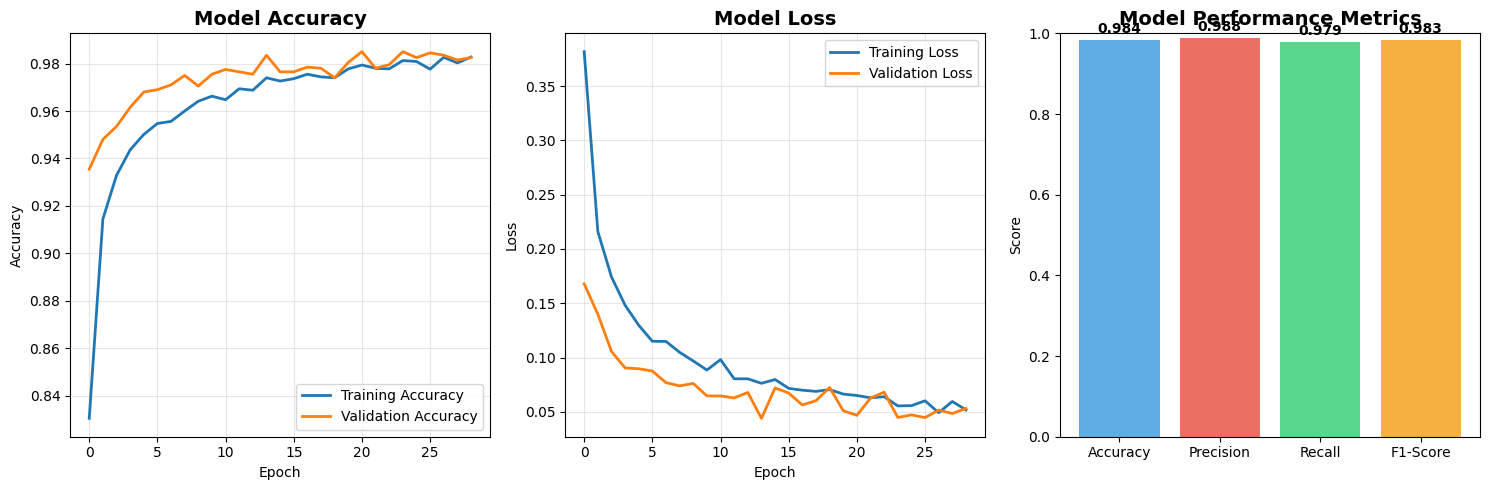


✅ Model training completed!
📁 Model saved: ../backend/models/advanced_protbert_model.h5
📁 Scalers saved: ../backend/models/protbert_scaler.pkl & statistical_scaler.pkl
💾 Embeddings cached: ../data/processed/protbert_embeddings.npy

🔬 Model Architecture Summary:
  - ProtBERT embeddings: 1024 features
  - Statistical features: 15 features
  - Multi-modal fusion with advanced regularization
  - Total parameters: 1,010,497


In [8]:
# Train-test split with stratification
X_train_emb, X_test_emb, X_train_stat, X_test_stat, y_train, y_test = train_test_split(
    protbert_scaled, statistical_scaled, labels, 
    test_size=0.2, random_state=42, stratify=labels
)

# Convert labels to numpy arrays (FIX for TensorFlow compatibility)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

print(f"\n📊 Data Split:")
print(f"  Training: {len(X_train_emb)} samples")
print(f"  Testing: {len(X_test_emb)} samples")
print(f"  ProtBERT features: {X_train_emb.shape[1]}")
print(f"  Statistical features: {X_train_stat.shape[1]}")
print(f"  Labels converted to numpy arrays: y_train.shape = {y_train.shape}, y_test.shape = {y_test.shape}")

# Build advanced model
print("\n🏗️  Building advanced multi-modal neural network...")
model = create_advanced_multimodal_model(protbert_scaled.shape[1], statistical_scaled.shape[1])
model.summary()

# Configure callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        '../backend/models/advanced_protbert_model.h5', 
        save_best_only=True, 
        monitor='val_loss',
        verbose=1
    )
]

# Train model
print("\n🚀 Training advanced model...")
history = model.fit(
    [X_train_emb, X_train_stat], y_train,
    validation_data=([X_test_emb, X_test_stat], y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate model
print("\n📊 Evaluating model performance...")
test_results = model.evaluate([X_test_emb, X_test_stat], y_test, verbose=0)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2] if len(test_results) > 2 else 0
test_recall = test_results[3] if len(test_results) > 3 else 0

# Calculate additional metrics
y_pred = model.predict([X_test_emb, X_test_stat], verbose=0)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

sklearn_precision = precision_score(y_test, y_pred_binary)
sklearn_recall = recall_score(y_test, y_pred_binary)
sklearn_f1 = f1_score(y_test, y_pred_binary)
sklearn_accuracy = accuracy_score(y_test, y_pred_binary)

print(f"\n=== FINAL MODEL PERFORMANCE ===")
print(f"Test Accuracy: {sklearn_accuracy:.4f}")
print(f"Test Precision: {sklearn_precision:.4f}")
print(f"Test Recall: {sklearn_recall:.4f}")
print(f"F1-Score: {sklearn_f1:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Enhanced visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Model training completed!")
print(f"📁 Model saved: ../backend/models/advanced_protbert_model.h5")
print(f"📁 Scalers saved: ../backend/models/protbert_scaler.pkl & statistical_scaler.pkl")
print(f"💾 Embeddings cached: ../data/processed/protbert_embeddings.npy")

print(f"\n🔬 Model Architecture Summary:")
print(f"  - ProtBERT embeddings: {protbert_scaled.shape[1]} features")
print(f"  - Statistical features: {statistical_scaled.shape[1]} features")
print(f"  - Multi-modal fusion with advanced regularization")
print(f"  - Total parameters: {model.count_params():,}")